In [7]:
# %%
import platform
import spiceypy as sp
import matplotlib.pyplot as plt
import numpy as np

from Groundtracks import ECIs2LonLats, SplitGroundtrack

#These imports are used for generating the example orbit and are not necessary for plotting the groundtrack
from Perturbations import SunSyncInc
from Kepler import muEarth, elms2rv
from Propagator import J2Propagate
if platform.system() == "Windows":
    # avert render bug in windows 10
    import plotly.offline as pyo
    pyo.init_notebook_mode()


Furnish the necessary kernel files for SpiceyPy

In [8]:
earth_img = plt.imread("Blue_Marble_2002.png")  #equirectangular projection of the Earth for the background image
"""SpiceyPy requires a NAIF time leapsecond kernel and an Earth shape file for converting from ECEF to ECI"""
tls_kernel = "naif0012.tls"     #https://naif.jpl.nasa.gov/pub/naif/generic_kernels/lsk/
pck_kernel = "pck00011.tpc"     #https://naif.jpl.nasa.gov/pub/naif/generic_kernels/pck/
sp.furnsh(tls_kernel)
sp.furnsh(pck_kernel)


Example: A Sun synchronous orbit with a 1 day repeat track

In [9]:
sidereal_day = ((23)*60+56)*60+4.09     #Earth rotation period
orb_day = 16                            #Number of orbits per sidereal day
T = sidereal_day/orb_day                #Orbit period
"""Keplerian elements"""
a = ((T/2/np.pi)**2*muEarth)**(1/3)     #semi-major axis
e = 0
i = SunSyncInc(a)                       #inclination necessary for sun-sync
omg = 20*np.pi/180
s = -60*np.pi/180
f = 0*np.pi/180

"""Timerange"""
t0 = sp.str2et("June 12 2023, 12 PM")
tf = sp.str2et("June 13 2023, 12 PM")
dt = 60
# convert elements to cartesian coords
r0, v0 = elms2rv(a, e, i, omg, 0, f, s)
# Propagate satellites with J2 perturbation in inertial frame
sol = J2Propagate(r0, v0, t0, tf, dt)

Next convert the inertial coordinates into geodetic coordinates and split the coordinates into seperate groundtracks every time the groundtrack passes over the anti-meridian

In [10]:
XI = sol.y[0,:]
YI = sol.y[1,:]
ZI = sol.y[2,:]
T = sol.t
#Get geodetic coordinates
lons,lats = ECIs2LonLats(T,XI,YI,ZI)

#split groundtrack everytime it crosses the antimeridian
split_T,split_lat,split_lon = SplitGroundtrack(T,lats,lons)

Plot each of the split groundtracks over an image of the Earth. Notice that there are gaps in the groundtracks around the antimeridian at high latitudes. This can be reduced by increasing the resolution of the orbital data or by interpolating what the coordinates of the groundtrack over the antimeridian should be and appending this coordinate to the split ground track.

Text(0.5, 1.0, 'Sun Synchronous 24 Hour Ground Track')

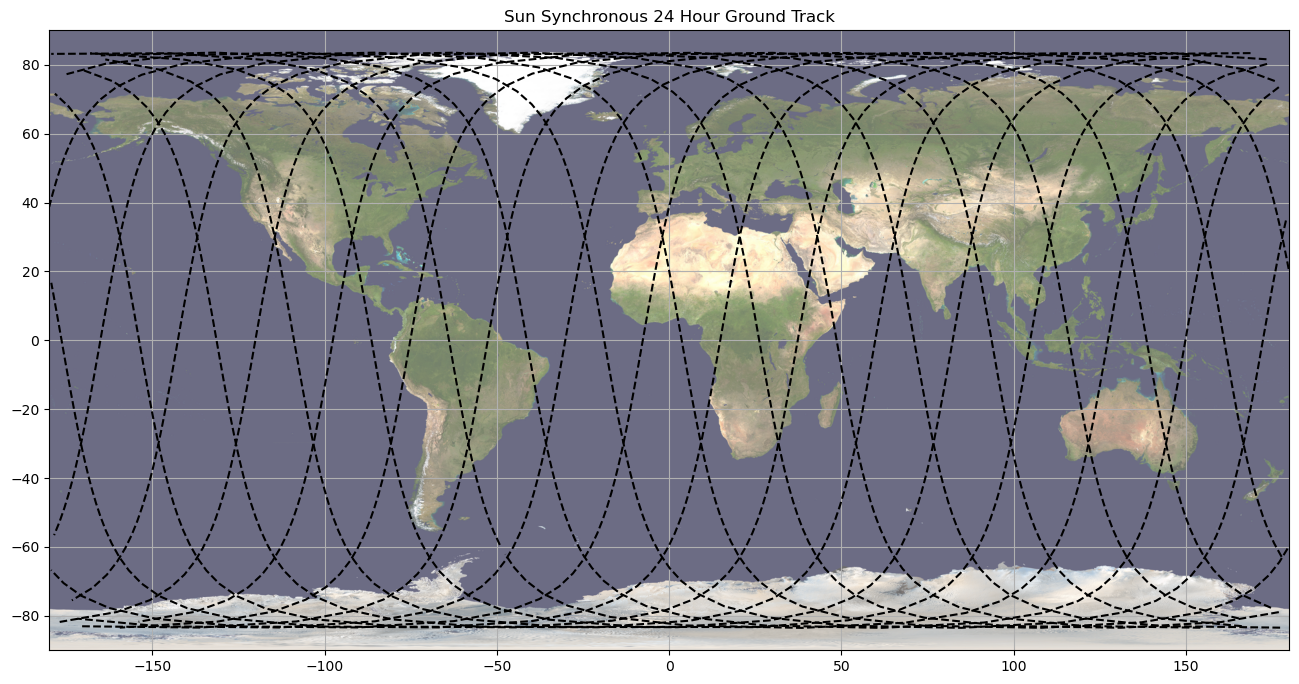

In [11]:

#plot the split tracks
fig = plt.figure("Groundtracks",figsize=(16,10))
ax = plt.gca()  #get current axis
ax.imshow(earth_img, extent=[-180,180,-90,90],alpha=0.6)    #plot equirectangular image of the Earth
ax.grid(True)
[ax.plot(lon, lat, '--', color='black') for lon,lat in zip(split_lat,split_lon)]    #plot each of the split groundtracks
ax.set_title('Sun Synchronous 24 Hour Ground Track')


Lastly, unload the Spice kernels

In [12]:
#Remove Kernels from memory
sp.kclear()